In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

rng = np.random.RandomState(8)
plt.style.use('dark_background')

Import Data frame

In [3]:
wine_df = pd.read_csv("DS\wine.csv")

Ammount of Wines in each class

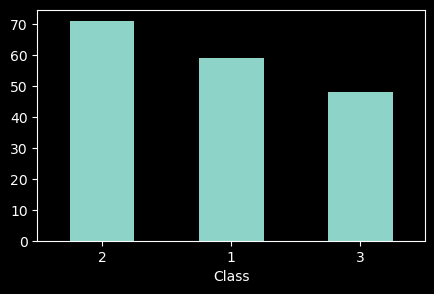

Class
2    71
1    59
3    48
Name: count, dtype: int64

In [59]:
plt.figure(figsize=(5,3))
wine_df["Class"].value_counts().plot(kind='bar')
plt.xticks(rotation=0)
plt.show()
wine_df['Class'].value_counts()

Feature distribution based on class

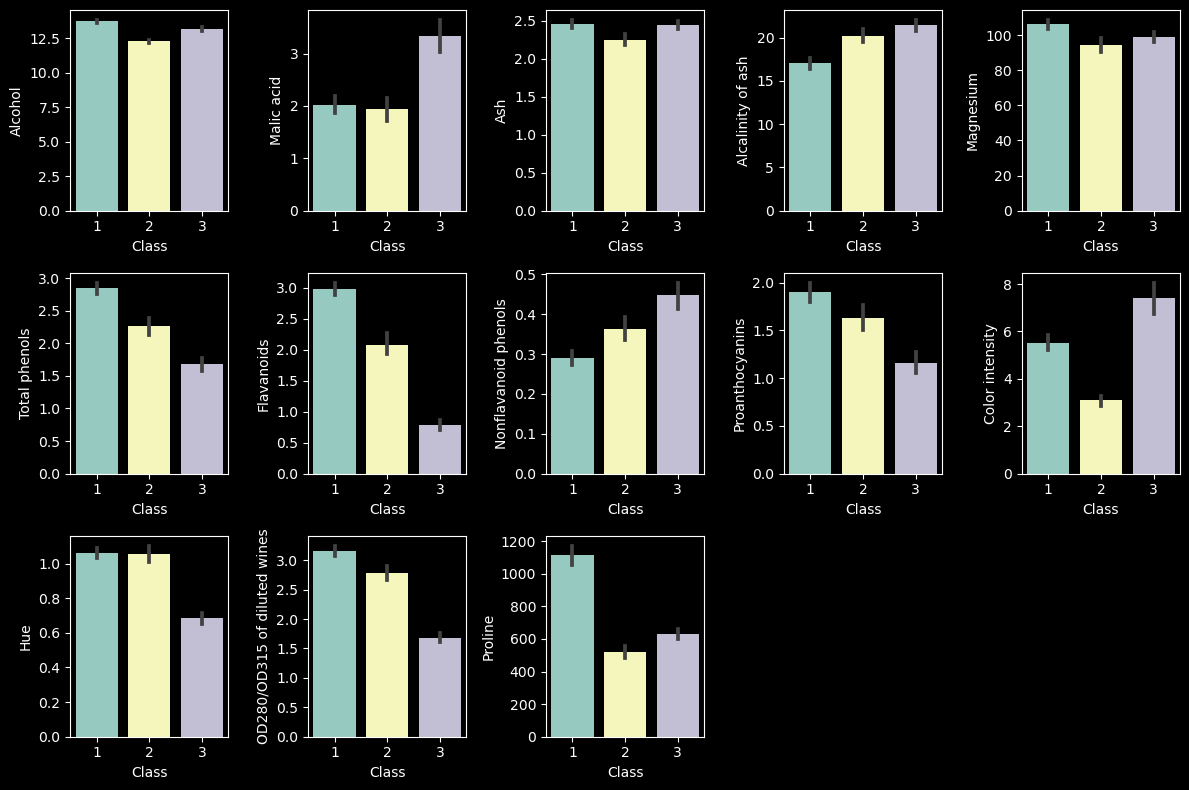

In [57]:
plt.figure(figsize=(12,8))
l=["Alcohol","Malic acid","Ash","Alcalinity of ash","Magnesium","Total phenols","Flavanoids","Nonflavanoid phenols","Proanthocyanins","Color intensity","Hue","OD280/OD315 of diluted wines","Proline"]
for i in l:
    plt.subplot(3, 5, l.index(i) + 1) 
    sns.barplot(x=wine_df["Class"],y=wine_df[i])
plt.tight_layout()
plt.show()

Feature distribution

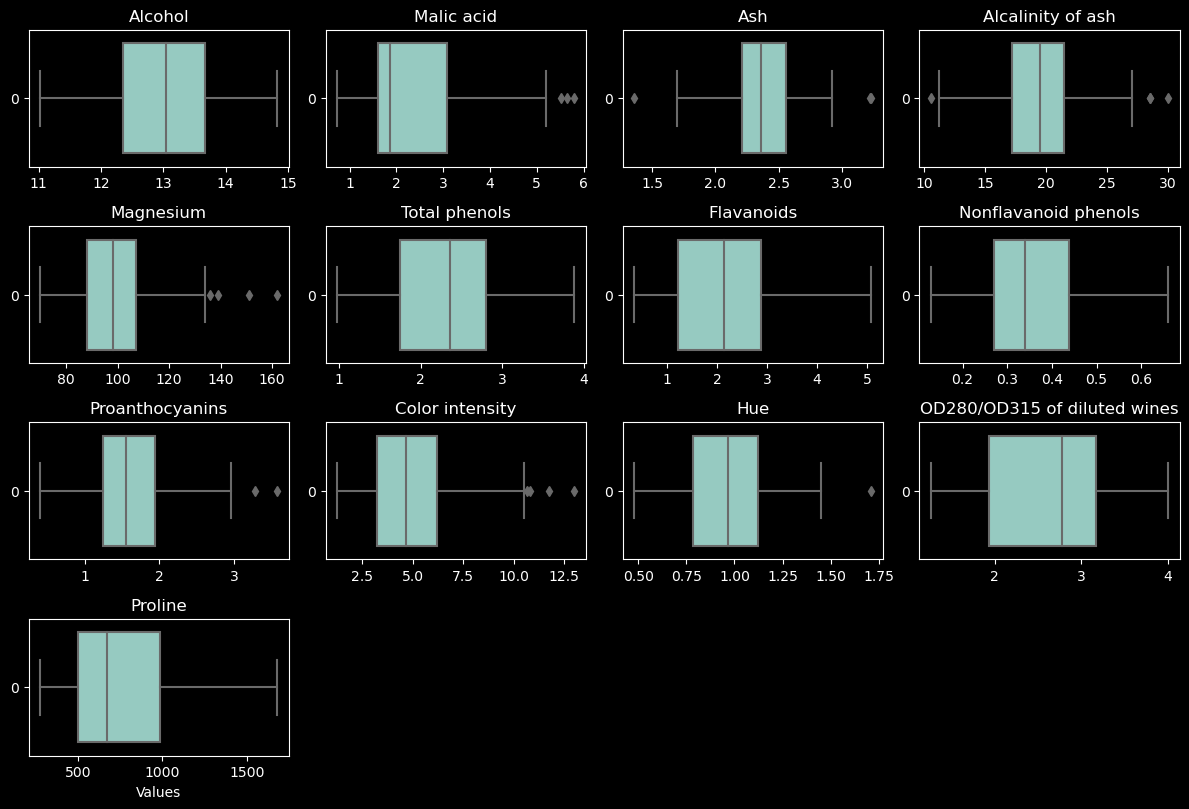

In [58]:
plt.figure(figsize=(12,8))
for i in l:
    plt.subplot(4, 4, l.index(i) + 1) 
    sns.boxplot(data=wine_df[i], orient='h')
    plt.title(i)
plt.tight_layout()
plt.xlabel('Values')
plt.show()

Correlation Heatmap

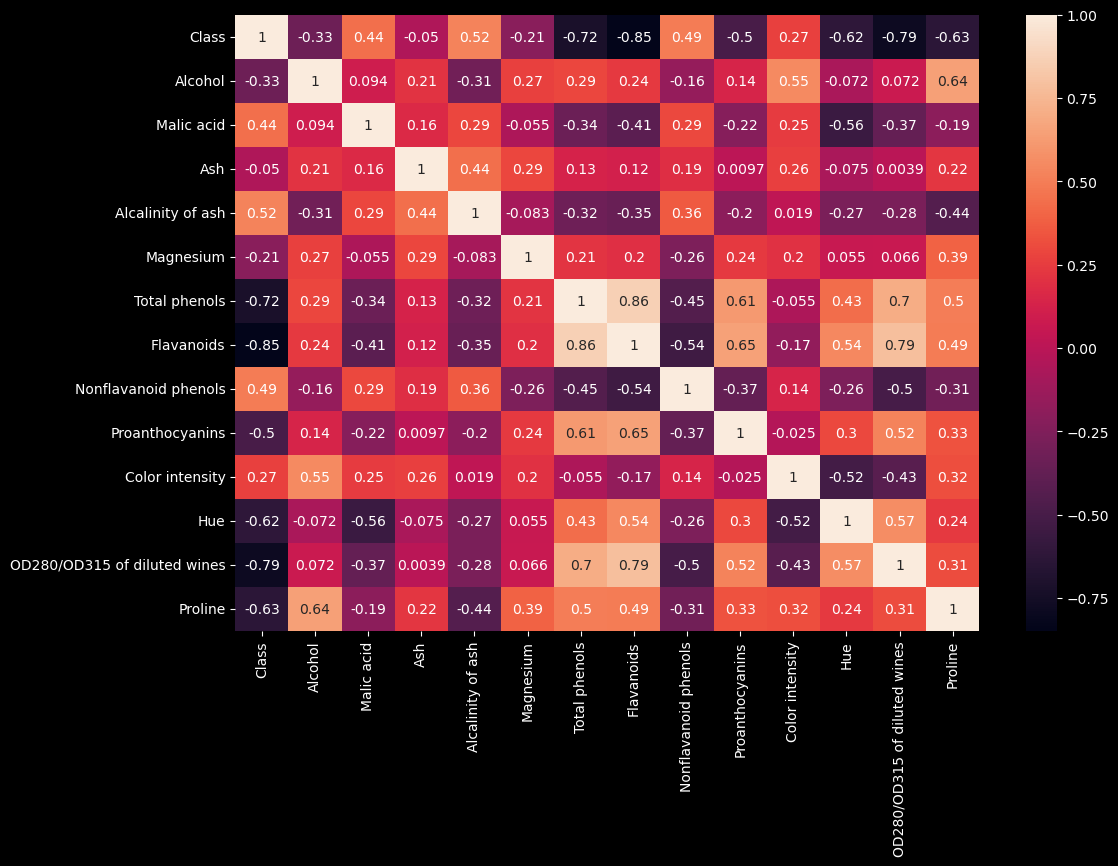

In [54]:
plt.figure(figsize=(12, 8))
cor=wine_df.corr()
sns.heatmap(cor,annot=True)
plt.show()

In [8]:
num_random_rows = 8

random_rows_df = wine_df.sample(n=num_random_rows, random_state=rng)
df = wine_df.drop(random_rows_df.index)

#Reset index
df.reset_index(drop=True, inplace=True)
random_rows_df.reset_index(drop=True, inplace=True)

df.info()
random_rows_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 170 entries, 0 to 169
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Class                         170 non-null    int64  
 1   Alcohol                       170 non-null    float64
 2   Malic acid                    170 non-null    float64
 3   Ash                           170 non-null    float64
 4   Alcalinity of ash             170 non-null    float64
 5   Magnesium                     170 non-null    int64  
 6   Total phenols                 170 non-null    float64
 7   Flavanoids                    170 non-null    float64
 8   Nonflavanoid phenols          170 non-null    float64
 9   Proanthocyanins               170 non-null    float64
 10  Color intensity               170 non-null    float64
 11  Hue                           170 non-null    float64
 12  OD280/OD315 of diluted wines  170 non-null    float64
 13  Proli

Split Dpendent and Independent Variables (x=data, y=target)

In [9]:
x = df.drop("Class", axis=1)
y = df["Class"]

x_random = random_rows_df.drop("Class", axis=1)
y_random = random_rows_df["Class"]

Stratified K-fold Random Forest

In [10]:
from sklearn.model_selection import StratifiedKFold, cross_val_predict,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report

splits = 10

RF = RandomForestClassifier(random_state=rng)
sk_folds = StratifiedKFold(shuffle=True, n_splits = splits, random_state=rng)

y_pred = cross_val_predict(RF, x, y, cv = sk_folds)

rf_score = cross_val_score(RF, x, y, cv = sk_folds)

print("accuracy:", rf_score.mean()*100, "%")
print(classification_report(y, y_pred))
rf_matrix = confusion_matrix(y,y_pred)
print(rf_matrix)

accuracy: 98.23529411764707 %
              precision    recall  f1-score   support

           1       0.98      0.98      0.98        56
           2       0.98      0.96      0.97        68
           3       0.96      1.00      0.98        46

    accuracy                           0.98       170
   macro avg       0.98      0.98      0.98       170
weighted avg       0.98      0.98      0.98       170

[[55  1  0]
 [ 1 65  2]
 [ 0  0 46]]


In [11]:
RF.fit(x,y)
predictions = RF.predict(x_random)
print(confusion_matrix(y_random,predictions))

[[3 0 0]
 [0 3 0]
 [0 0 2]]


In [12]:
#CasaSantos_df = pd.read_csv("DS\wine-tiago.csv")

#trash = CasaSantos_df

#predict_trash = RF.predict(trash)
#print(predict_trash)


SMOTE

In [13]:
from collections import Counter
from imblearn.over_sampling import SMOTE

oversample = SMOTE(random_state=rng)
x_res, y_res = oversample.fit_resample(x, y)
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({1: 68, 2: 68, 3: 68})


Stratified K-fold SMOTE Random Forest

In [73]:
y_res_pred = cross_val_predict(RF, x_res, y_res, cv = sk_folds)

rf_pred_score = cross_val_score(RF, x_res, y_res, cv = sk_folds)

print("accuracy:", rf_pred_score.mean()*100, "%")
print(classification_report(y_res,y_res_pred))
rf_pred_matrix = confusion_matrix(y_res,y_res_pred)
print(rf_pred_matrix)

accuracy: 98.52380952380952 %
              precision    recall  f1-score   support

           1       0.99      1.00      0.99        68
           2       1.00      0.94      0.97        68
           3       0.96      1.00      0.98        68

    accuracy                           0.98       204
   macro avg       0.98      0.98      0.98       204
weighted avg       0.98      0.98      0.98       204

[[68  0  0]
 [ 1 64  3]
 [ 0  0 68]]


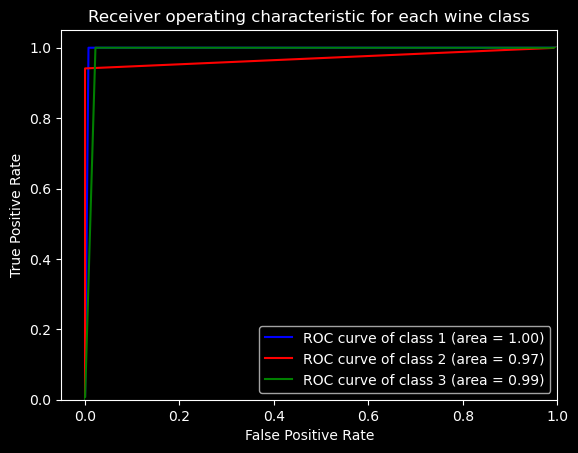

In [75]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

y_bin = label_binarize(y_res, classes=[1,2,3])
y_pred_bin = label_binarize(y_res_pred, classes=[1,2,3])
n_classes = y_bin.shape[1]

fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
colors = cycle(['blue', 'red', 'green'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i+1, roc_auc[i]))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic for each wine class')
plt.legend(loc="lower right")
plt.show()

XGBoost 10 fold

In [76]:
y_xgb = y-1
y_res_xgb = y_res-1

import xgboost as xgb
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
}

xgb_model = xgb.XGBClassifier()

grid_search = GridSearchCV(xgb_model, param_grid, cv=10, scoring='accuracy')

grid_search.fit(x, y_xgb)

# Print the best set of hyperparameters and the corresponding score
print("Hyperparameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_*100, "%")

Hyperparameters:  {'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.5}
Best score:  98.23529411764707 %
